In [1]:
import numpy as np
import pandas as pd
import data_lib
import plot_lib
import decision_lib
from sklearn import cluster
import validation_lib
import transform_lib

np.random.seed(200)

In [2]:
# print available data summary
data_dict = data_lib.explore_datasets(datafolder="../../Data",verbose=True)
print(data_lib.LABELS_LIST)

----------------------------------------------------------------------------------------------
-- The following 4 groups were found
-- They contain 40 datasets
-- The first printed entity is the key to the returned dictionary
-----------------------------------
Group: ../../Data/6P-positive-dilution-series-2-labelled/droplet-level-data/RawData
po-di-se-2-A4, files: 13                po-di-se-2-C4, files: 13                po-di-se-2-A1, files: 13
po-di-se-2-B1, files: 13                po-di-se-2-D1, files: 13                po-di-se-2-B4, files: 13
po-di-se-2-C1, files: 13                po-di-se-2-D4, files: 13                
-----------------------------------
Group: ../../Data/6P-positive-dilution-series-1-labelled/droplet-level-data/RawData
po-di-se-1-D4, files: 13                po-di-se-1-A4, files: 13                po-di-se-1-A1, files: 13
po-di-se-1-D1, files: 13                po-di-se-1-B1, files: 13                po-di-se-1-C1, files: 13
po-di-se-1-B4, files: 13         

### Get samples for negative control

In [3]:


# load the necessary datasetes
df_di = data_lib.load_dataset(None, [
    #"po-di-se-2-A4", 
    #"po-di-se-2-B1", "po-di-se-2-C1", "po-di-se-2-C4",
    #"po-di-se-2-D1",
    #"po-di-se-2-D4",
    #"po-di-se-2-A1", "po-di-se-2-B4",

    "po-di-se-1-D4",
    "po-di-se-1-D1",
    "po-di-se-1-B4", 
    "po-di-se-1-A4",
    #"po-di-se-1-B1", "po-di-se-1-C4", "po-di-se-1-A1", 
    "po-di-se-1-C1",

    #"po-di-se-B8",
    #"po-di-se-D8",
    #"po-di-se-A8",
    #"po-di-se-C8",
                                     ], 
                              datafolder="../../Data")


df_negative_control = data_lib.load_dataset([],[
    "po-di-se-1-D1",
    "po-di-se-1-D4",
    "po-di-se-2-D1", 
    "po-di-se-2-D4",
    "po-di-se-D8",
                                                ], 
                                            datafolder="../../Data")
# Everything is positive contol
df_positive_control = df_di.iloc[:,:6]

# convert to numpy
np_di = df_di.to_numpy(copy=True)[:,:6]
np_negative_control = None # df_negative_control.to_numpy()

In [4]:
# fix clustering algorithm
prediction_axis = ['SARS-N2_POS','SARS-N1_POS','IBV-M_POS','RSV-N_POS','IAV-M_POS','MHV_POS']
whitening_engine = transform_lib.WhitenTransformer(whiten=transform_lib.Whitenings.NONE)
num_cluster = int(2**len(prediction_axis) * 2)
cluster_engine = cluster.KMeans(n_clusters=num_cluster, n_init='auto')
#cluster_engine = cluster.DBSCAN(eps=0.2, n_jobs=4, min_samples=6, leaf_size=5)
#cluster_engine = mixture.GaussianMixture(n_components=100)
decision = decision_lib.WhitnesDensityClassifier(
                                     negative_control=np_negative_control,
                                     cluster_algorithm=cluster_engine,
                                     whitening_transformer=whitening_engine,
                                     negative_range=0.95,
                                     eps=0.35,
                                     outlier_quantile=0.004,
                                     prediction_axis=prediction_axis,
                                     verbose=True
                                     )
df_decision = decision.predict(np_di)

Finished compute clusters in 1.3203840255737305 seconds
Finished compute transformed features in 0.38768434524536133 seconds
Finished predict cluster labels in 0.9633755683898926 seconds
Finished predict labels in 0.12066388130187988 seconds


## Plot the predictions

- Black = True negative prediction
- Green = True positive prediciton
- Purple = False negative
- Red = False positive
- yellow = outlier

#### Plot for all diseases predictions against ground truth

Firs plot is in the decorrelated coordinates, whereas the second is in original coordinates

Outlier rate: 0.004004526856446418, n_outlier: 506

Total error rate: 0.011837134785866283
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.005669     0.038403   0.014544   0.004206   0.003746 0.004454

Precision (TP / (TP + FP)): 0.999053734449868
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.999077     0.998589   0.997106   0.999857   0.999774  0.99943

Recall / TPR (TP / (TP + FN)): 0.9993258605550565
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.999927     0.998971   0.998575   0.999035   0.999662 0.999753

Specificity / TNR (TN / (TN + FP)): 0.9998665122272697
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.999888     0.999871   0.999589   0.999974   0.999963 0.999917

Accuracy ((TP + TN) / (P + N)): 0.9997997617742966
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.999892     0.999796   0.999463   0.999827   0.999921 0.999896

F1 (2 * (precision * r

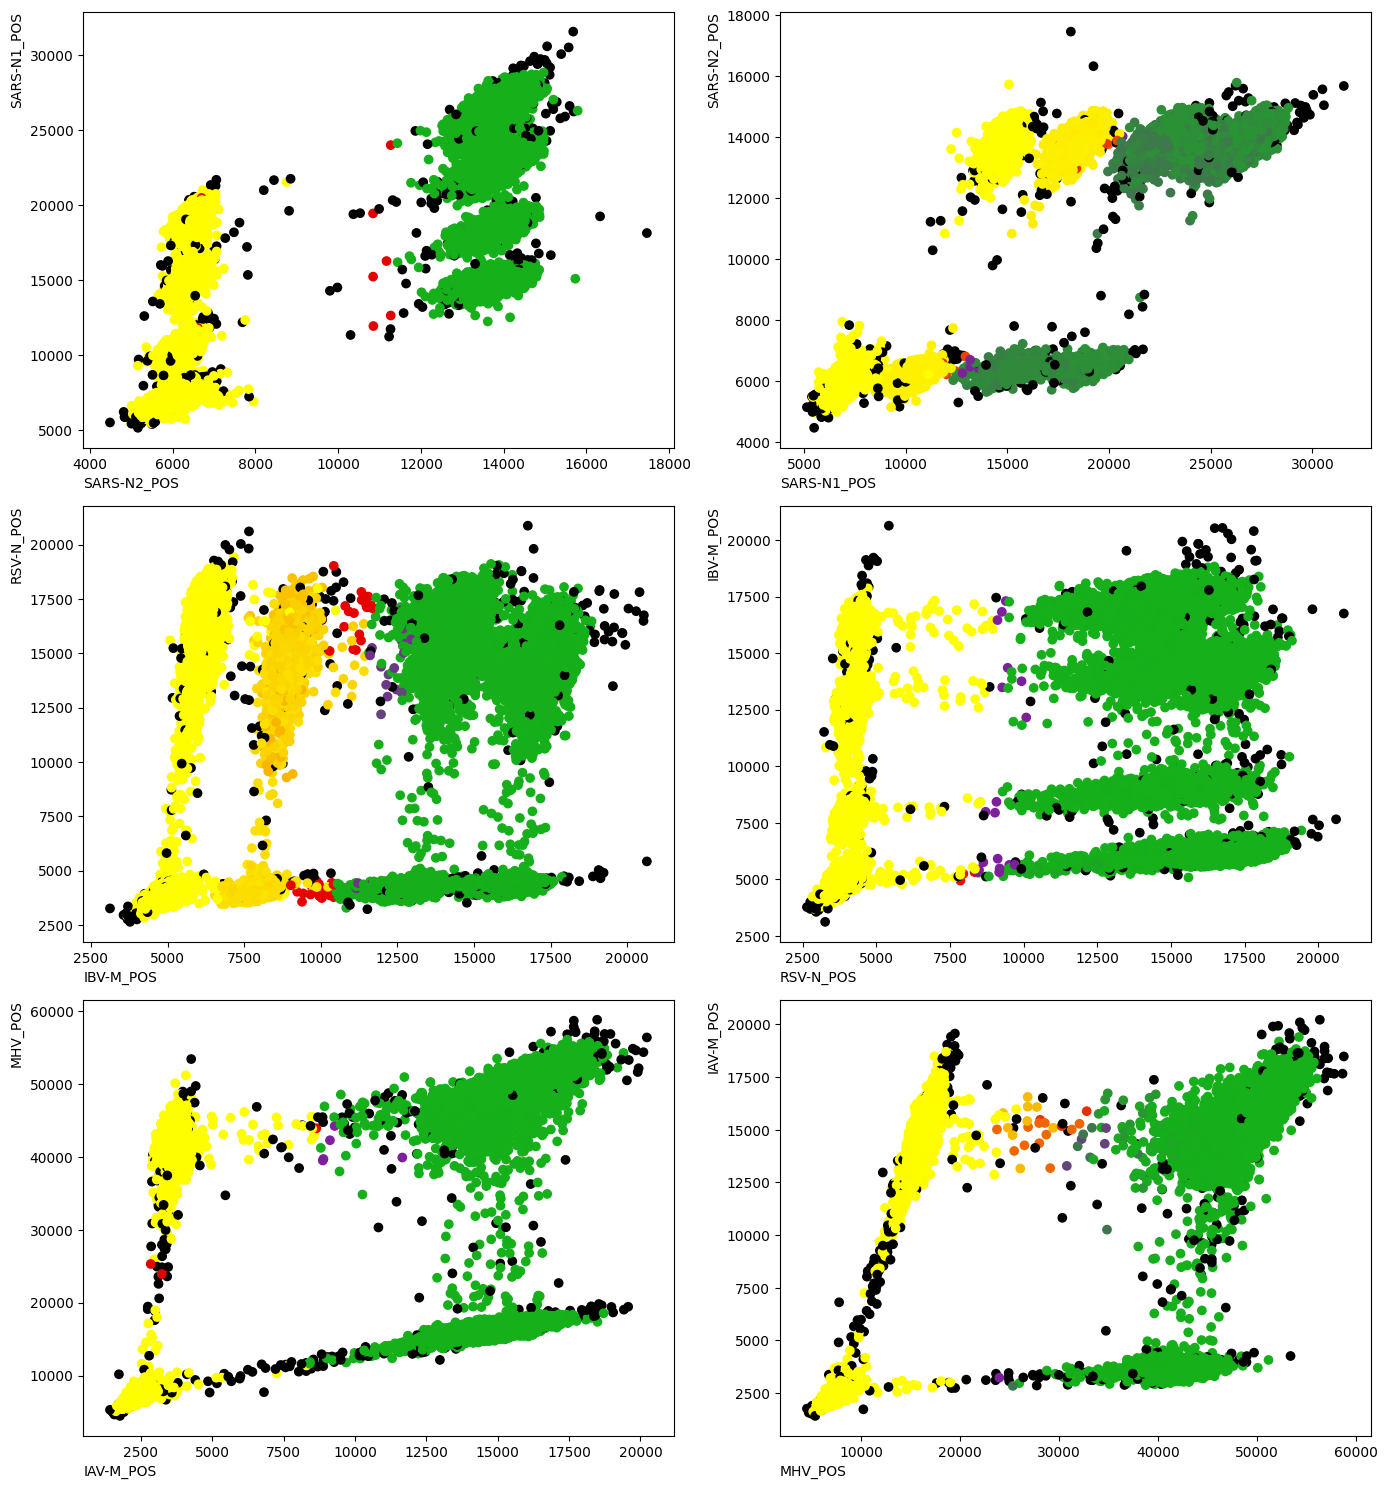

In [5]:

df_data_points = pd.DataFrame(data=decision.X, columns=prediction_axis) 
df_predictions = decision.probabilities_df
df_ground_trouth = df_di
selected_pairs = [
                ('SARS-N2_POS','SARS-N1_POS'),
                ('SARS-N1_POS','SARS-N2_POS'),
                ('IBV-M_POS','RSV-N_POS'),
                ('RSV-N_POS','IBV-M_POS'),
                ('IAV-M_POS','MHV_POS'),
                ('MHV_POS','IAV-M_POS'),
                ]

mask = decision.No_neg_mask
validation_lib.validate_labels(df_true_labels=df_di, df_predicted_labels=df_predictions, verbosity=1, threshold=0.5)

#df_result = stats_lib.compute_results(df_predictions, 0.40, 0.60, df_data_points)

plot_lib.plot_pairwise_selection_bayesian(
        df_data_points,
        df_predictions,
        df_ground_trouth,
        selected_pairs,
        n_cols=2,
        mask=mask,
        )

In [6]:
validation_lib.validate_combinations(df_di, df_predictions, verbosity=0)

Total number of outlayer: 506

Label combination ('SARS-N2_POS',):
n outliers: 5, n_true_pos: 0
Balanced Accuracy: No evaluation possible

Label combination ('SARS-N1_POS',):
n outliers: 3, n_true_pos: 0
Balanced Accuracy: No evaluation possible

Label combination ('IBV-M_POS',):
n outliers: 2, n_true_pos: 0
Balanced Accuracy: No evaluation possible

Label combination ('RSV-N_POS',):
n outliers: 10, n_true_pos: 0
Balanced Accuracy: No evaluation possible

Label combination ('IAV-M_POS',):
n outliers: 15, n_true_pos: 0
Balanced Accuracy: No evaluation possible

Label combination ('MHV_POS',):
n outliers: 10, n_true_pos: 0
Balanced Accuracy: No evaluation possible

Label combination ('SARS-N2_POS', 'SARS-N1_POS'):
n outliers: 4, n_true_pos: 0
Balanced Accuracy: No evaluation possible

Label combination ('SARS-N2_POS', 'IBV-M_POS'):
n outliers: 4, n_true_pos: 0
Balanced Accuracy: No evaluation possible

Label combination ('SARS-N2_POS', 'RSV-N_POS'):
n outliers: 6, n_true_pos: 0
Balanced 

In [7]:
#df_result.to_csv("test_di.csv")

In [8]:
decision.assign_true_cluster_labels(df_gt=df_ground_trouth)
print(-2, decision.prediction_axis)
for c in decision.cluster_dict.keys():
    #print(c, decision.cluster_dict[c].active)
    pass

-2 ['SARS-N2_POS', 'SARS-N1_POS', 'IBV-M_POS', 'RSV-N_POS', 'IAV-M_POS', 'MHV_POS']


(Partially) falsely classified clusters [80, 95]


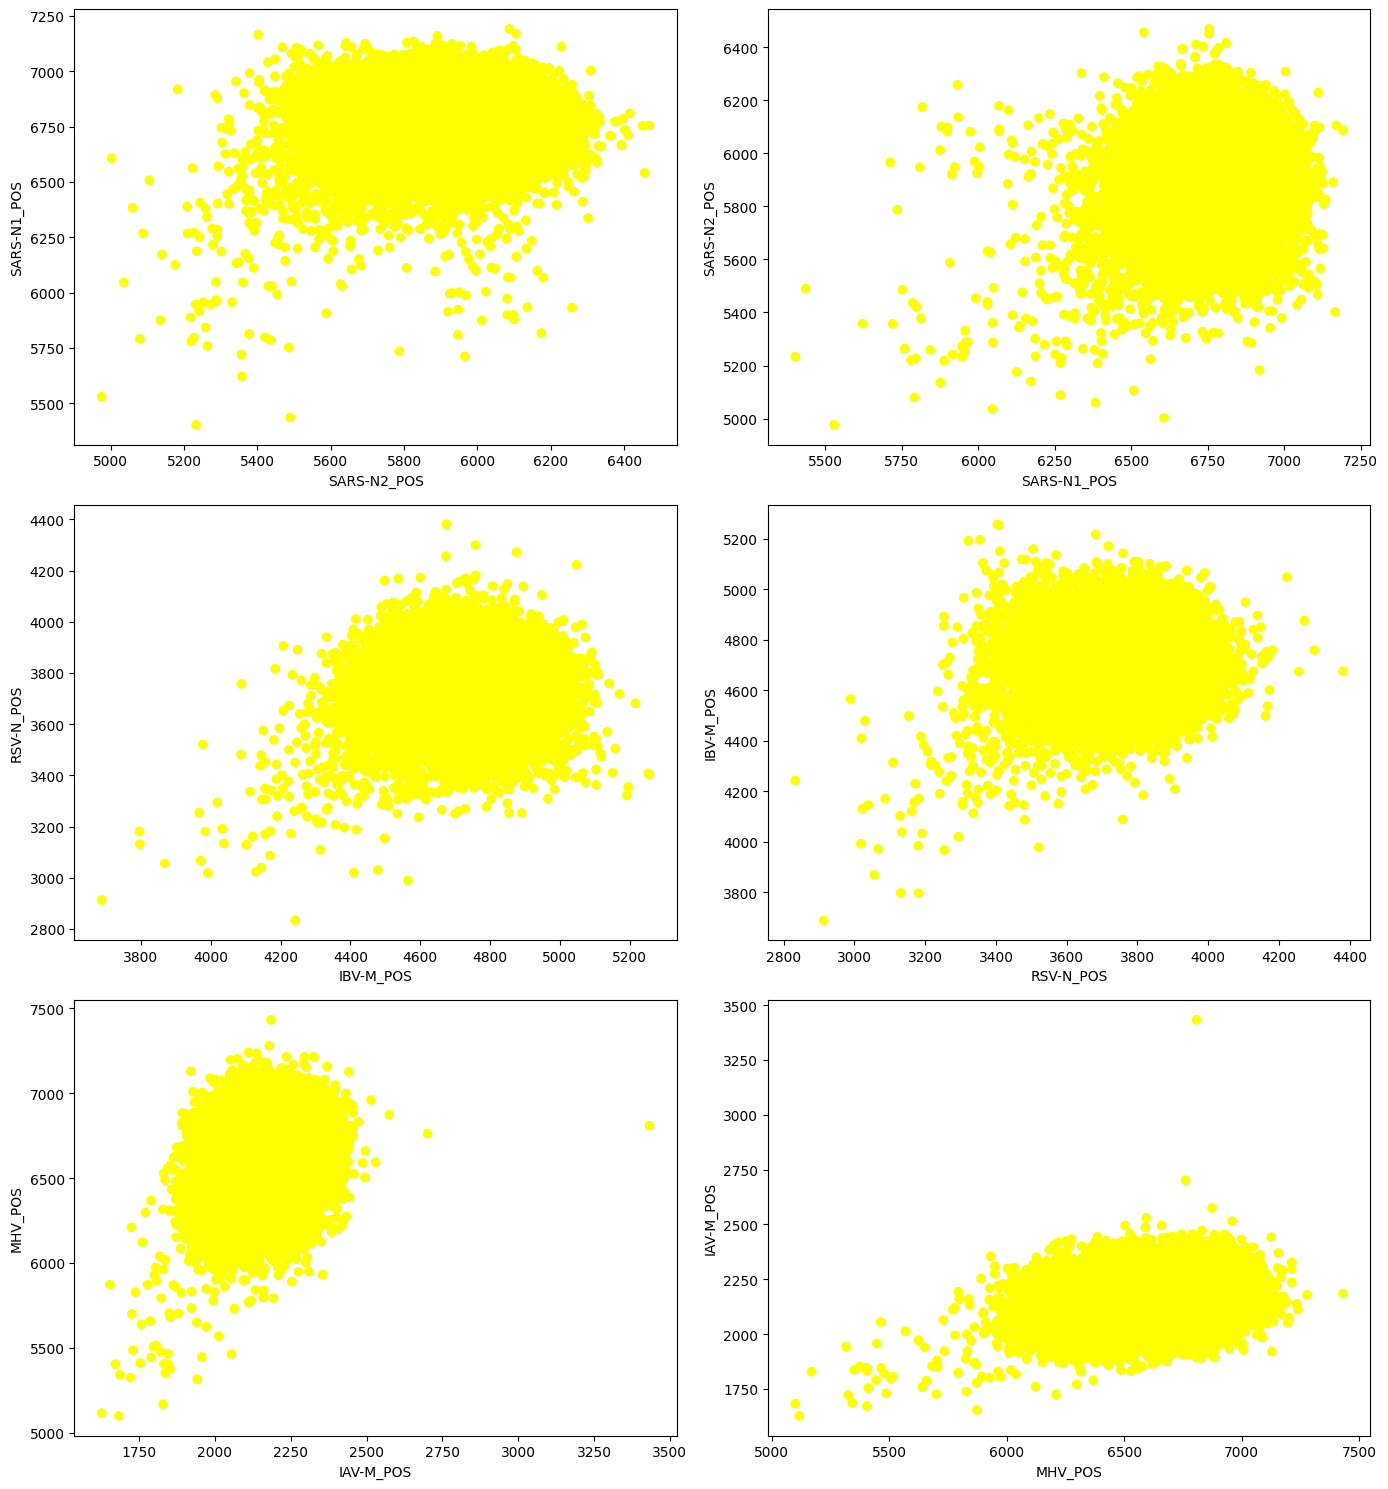

In [9]:

false_clusters = [80,95]
df_false_data, df_false_predictions, df_false_ground_truth = validation_lib.get_false_cluster_for_plotting(df_data_points=df_data_points,
                                                                                                           df_predictions=df_predictions,
                                                                                                           df_ground_truth=df_ground_trouth,
                                                                                                           clusters=decision.cluster_dict,
                                                                                                           false_clusters=false_clusters)
print(f"(Partially) falsely classified clusters {false_clusters}")
plot_lib.plot_pairwise_selection(data_points=df_false_data, selected_pairs=selected_pairs, predictions=df_false_predictions, ground_trouth=df_false_ground_truth)

In [10]:
validation_lib.get_negative_percent(df_ground_trouth, prediction_axis)

ic| negative_count.shape: (6,)
ic| negative_percent.shape: (6,)
ic| axis: ['SARS-N2_POS', 'SARS-N1_POS', 'IBV-M_POS', 'RSV-N_POS', 'IAV-M_POS', 'MHV_POS']
ic| all_neg.shape: ()
ic| all_neg_per.shape: ()
ic| np.var(np_points, axis=0): array([0.09710716, 0.09919805, 0.10906247, 0.13282259, 0.12194537,
                                      0.11199437])


Positive count: 
   SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
0        13771        14110      15742      19925      17962    16238
Positive percent: 
   SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS   MHV_POS
0     0.108985     0.111668   0.124584   0.157688   0.142153  0.128509
Negative percent: 
   SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS   MHV_POS
0     0.891015     0.888332   0.875416   0.842312   0.857847  0.871491
All neg Count count: 
90533
All neg percent: 
0.7164858298313509
All pos percent: 
0.2835141701686491
